In [13]:
# Carregando as bibliotecas

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import yfinance as yf

[*********************100%***********************]  1 of 1 completed


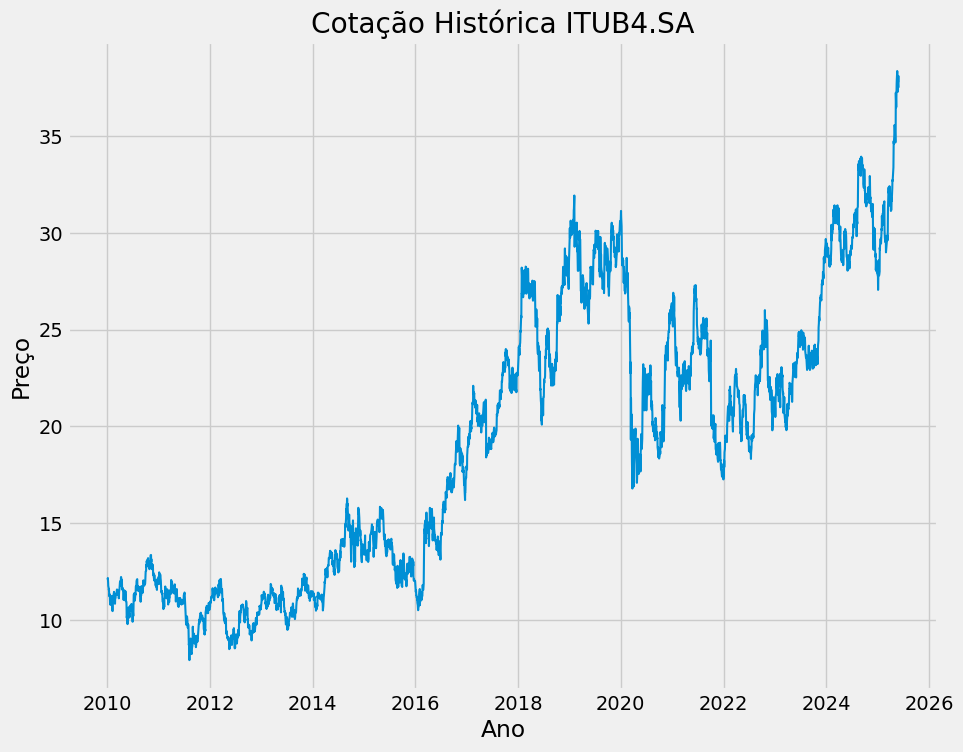

In [14]:
# Carregando a base de dados e fazendo os checks iniciais

plt.style.use("fivethirtyeight")

# Carrega a base
ticker = "ITUB4.SA"
inicio = "2010-01-01"
fim = datetime.today().strftime("%Y-%m-%d")
df1 = yf.download(ticker, inicio, fim, auto_adjust=False)
df1.columns=df1.columns.get_level_values(0)

with plt.style.context("fivethirtyeight"):
    plt.figure(figsize = (10, 8))
    plt.plot(df1["Adj Close"], linewidth = 1.5)
    plt.xlabel("Ano")
    plt.ylabel("Preço")
    plt.title("Cotação Histórica " + ticker)
    plt.show();

In [15]:
# Calculando os retornos diários, dentro e fora do dataframe

df1["Retorno"] = df1["Adj Close"].pct_change(1)

retornos = df1["Adj Close"].pct_change(1).dropna().to_numpy()

In [16]:
retornos

array([ 0.00648101, -0.00866747, -0.01024318, ...,  0.00793649,
       -0.00813642, -0.00793859])

In [17]:
# Vamos considerar 3 anos para frente e que 1 ano tenha 252 dias úteis 

anos = 3
num_dias = anos * 252
ultimo_preco = float(df1["Adj Close"].tail(1))

In [18]:
ultimo_preco

37.4900016784668

In [19]:
# E vamos calcular o drawdown máximo

# Simula os retornos diários dos próximos 3 anos
sim_ret = np.random.choice(retornos, size = num_dias, replace = True)

# Faz o cálculo do valor da carteira com retorno composto
sim_val = ultimo_preco*(1 + sim_ret).cumprod()

# Calcula o valor máximo da carteira simulada
max_val = np.maximum.accumulate(sim_val)

# Encontra o drawdown máximo
max_dd = np.max((max_val - sim_val)/max_val)

max_dd

0.5364704580415984

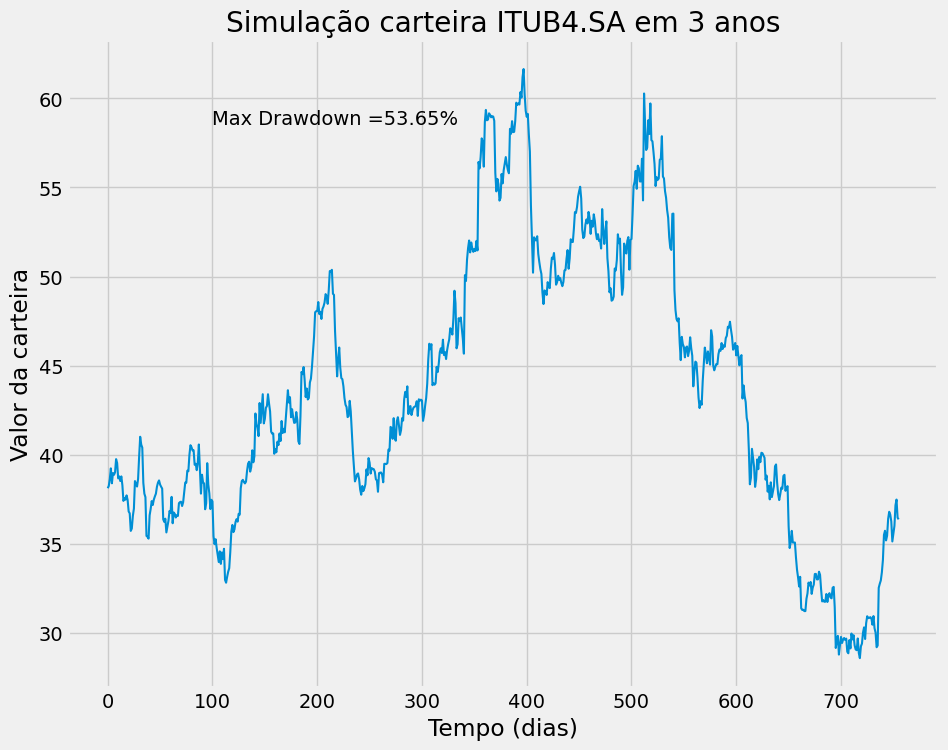

In [20]:
# Visualização da simulação do valor da carteira

with plt.style.context("fivethirtyeight"):
    plt.figure(figsize = (10, 8))
    plt.plot(sim_val, linewidth = 1.5)
    plt.xlabel("Tempo (dias)")
    plt.ylabel("Valor da carteira")
    plt.annotate("Max Drawdown =" + str(round(max_dd*100, 2)) + "%", (100, np.max(sim_val)*0.95))
    plt.title("Simulação carteira " + ticker + " em " + str(anos) + " anos")
    plt.show();

In [21]:
# Vamos ao Monte Carlo com X simulações 

num_sim = 100000

dd = np.array([])

for n in range(num_sim): # basta colocar a lógica anterior dentro de um laço for
    # Simula os retornos diários dos próximos 3 anos
    sim_ret = np.random.choice(retornos, size = num_dias, replace = True)

    # Faz o cálculo do valor da carteira com retorno composto
    sim_val = ultimo_preco*(1 + sim_ret).cumprod()

    # Calcula o valor máximo da carteira simulada
    max_val = np.maximum.accumulate(sim_val)

    # Encontra o drawdown máximo
    max_dd = np.max((max_val - sim_val)/max_val)
    dd = np.append(dd, max_dd)

In [22]:
dd

array([0.33097164, 0.69237624, 0.39236653, ..., 0.5395264 , 0.49923558,
       0.35332245])

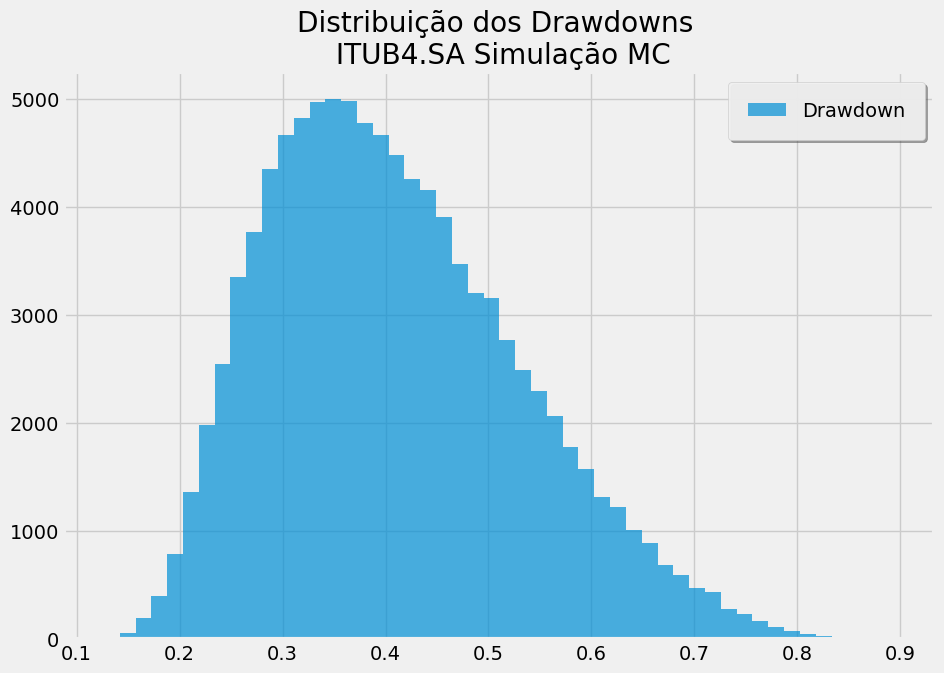

In [23]:
# Vamos visualizar a distribuição dos drawdowns

config = dict(histtype = "stepfilled", alpha = 0.7, density = False, bins = 50)

plt.figure(figsize = (10,7))
plt.hist(dd, **config, label = "Drawdown")

# Formataçao da legenda - Valida para qualquer tipo de grafico
plt.legend(loc = "upper right"
           , frameon = True
           , ncol = 2 
           , fancybox = True
           , framealpha = 0.95
           , shadow = True
           , borderpad = 1)
plt.title("Distribuição dos Drawdowns \n " + ticker + " Simulação MC")
plt.show();

In [24]:
# Por fim, as estatísticas importantes

print("Para o ativo " + ticker + " segundo uma simulação de Monte Carlo,")
print("com " + str(num_sim) + " simulações, em " + str(anos) + " anos podemos esperar:")
print()
print("---------------------------------------------------------")
print("Drawdown médio " + str(round(np.mean(dd*100), 2)) + "%")
print()
print("Com: ")
print("    50% de probabilidade, o DD será maior do que " + str(round(np.median(dd*100), 2)) + "%")
print("    25% de probabilidade, o DD será maior do que " + str(round(np.percentile(dd*100, 75), 2)) + "%")
print("     5% de probabilidade, o DD será maior do que " + str(round(np.percentile(dd*100, 95), 2)) + "%")
print("---------------------------------------------------------")
print()
print("Período dos parâmetros para a simulação: " + inicio  + " à " + fim)

Para o ativo ITUB4.SA segundo uma simulação de Monte Carlo,
com 100000 simulações, em 3 anos podemos esperar:

---------------------------------------------------------
Drawdown médio 40.91%

Com: 
    50% de probabilidade, o DD será maior do que 39.39%
    25% de probabilidade, o DD será maior do que 48.9%
     5% de probabilidade, o DD será maior do que 63.45%
---------------------------------------------------------

Período dos parâmetros para a simulação: 2010-01-01 à 2025-05-30


Quanto voce pode ter alocado em uma carteira e perder

O problema da simulação de monte carlo é que ela admite que os dados pertencem a uma distribuição normal